In [78]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
import shap



In [79]:
df=pd.read_csv("./heart.csv")
df.head()
df.rename(columns={'cp': 'ChestPainType', 
                   'trtbps': 'RestingBP',
                   'chol':'Cholesterol',
                   'fbs':'FastingBS',
                   'restecg':'RestingECG',
                   'thalachh':'MaxHR',
                   'exng':'ExerciseAngina',
                   'oldpeak':'OldPeak',
                   'thall':'Thalium',
                   'slp':'Slope',
                   'caa':'MajorBloodVessels'}, inplace=True)
df.head()

,age,sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,OldPeak,Slope,MajorBloodVessels,Thalium,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [80]:
df.dtypes

age                    int64
sex                    int64
ChestPainType          int64
RestingBP              int64
Cholesterol            int64
FastingBS              int64
RestingECG             int64
MaxHR                  int64
ExerciseAngina         int64
OldPeak              float64
Slope                  int64
MajorBloodVessels      int64
Thalium                int64
output                 int64
dtype: object

In [81]:
num_col=df.columns.to_list()
num_col.remove('output')
num_col

['age',
 'sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'OldPeak',
 'Slope',
 'MajorBloodVessels',
 'Thalium']

In [82]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
ChestPainType,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
RestingBP,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
Cholesterol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
FastingBS,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
RestingECG,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
MaxHR,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
ExerciseAngina,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
OldPeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [83]:
px.imshow(df.corr(),title="Correlation Plot of the Heat Failure Prediction")

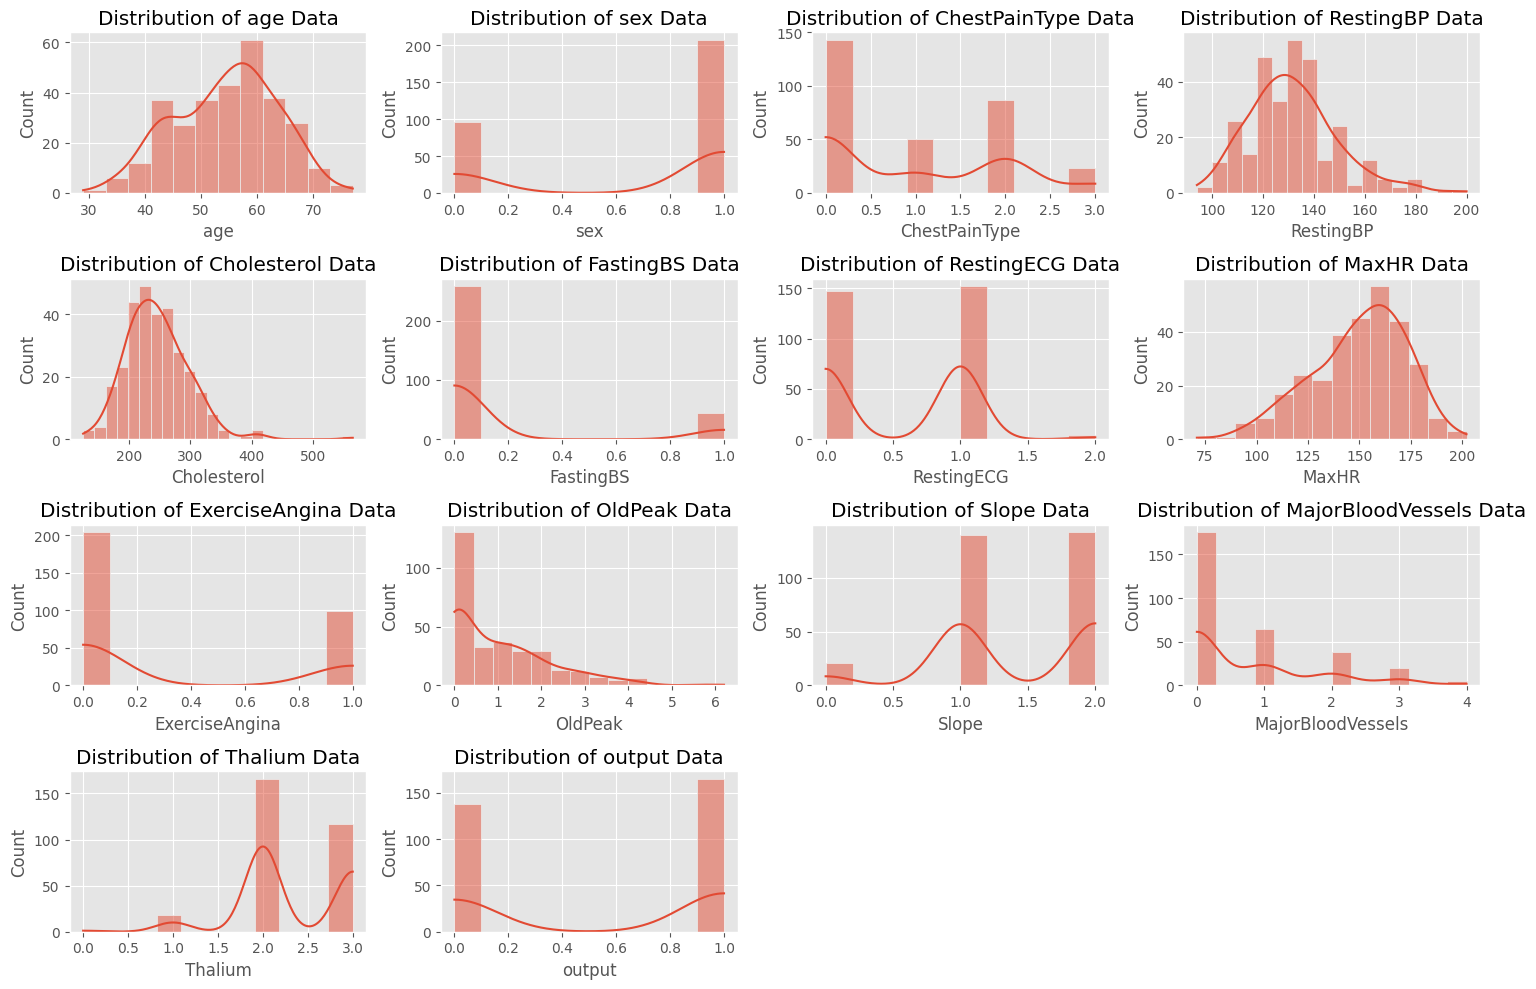

In [84]:
# plt.figure(figsize=(15,10))
# sns.pairplot(df,hue="output")
# plt.title("Looking for Insites in Data")
# plt.legend("output")
# plt.tight_layout()
# plt.plot()

plt.figure(figsize=(15,10))

for i, col in enumerate(df.columns,1):
    plt.subplot(4,4,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()


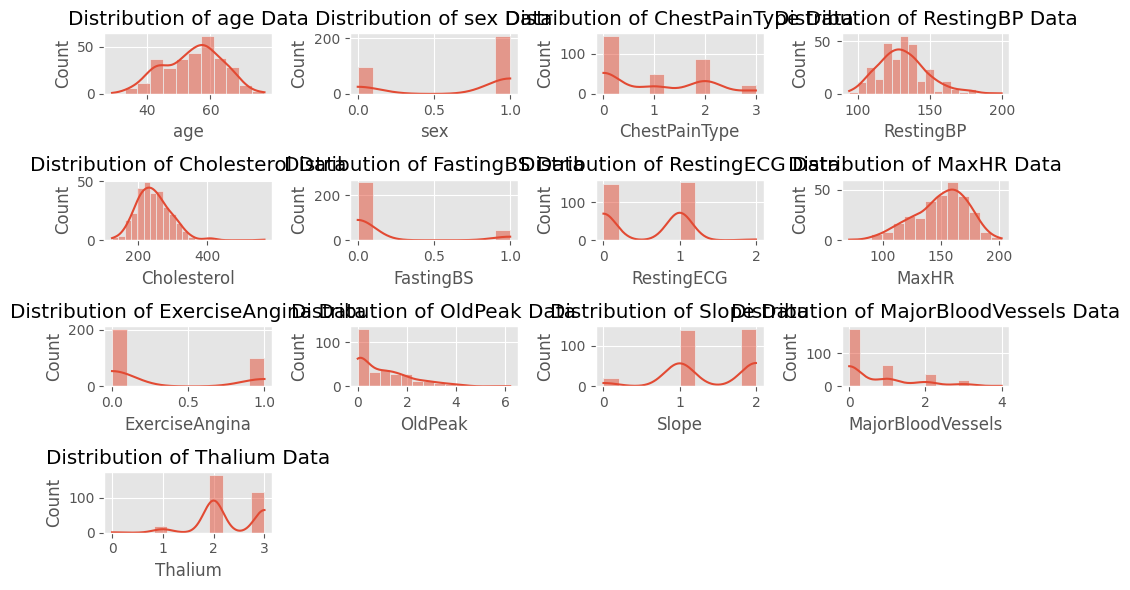

In [85]:
plt.figure(figsize=(10, 6))  # Change the figsize to a smaller size

for i, col in enumerate(num_col, 1):
    plt.subplot(4, 4, i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col], kde=True)
    plt.tight_layout()
    plt.plot()
    
    fig = px.box(df, y=col, x="output", title=f"Distribution of {col} Data")
    fig.update_layout(
        autosize=False,
        width=400,
        height=400,
        )
    fig.show()


In [86]:
df.info()
df.isnull().sum()
target = "output"
y=df[target]
x=df.drop(target,axis=1)
y.value_counts()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                303 non-null    int64  
 1   sex                303 non-null    int64  
 2   ChestPainType      303 non-null    int64  
 3   RestingBP          303 non-null    int64  
 4   Cholesterol        303 non-null    int64  
 5   FastingBS          303 non-null    int64  
 6   RestingECG         303 non-null    int64  
 7   MaxHR              303 non-null    int64  
 8   ExerciseAngina     303 non-null    int64  
 9   OldPeak            303 non-null    float64
 10  Slope              303 non-null    int64  
 11  MajorBloodVessels  303 non-null    int64  
 12  Thalium            303 non-null    int64  
 13  output             303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


output
1    165
0    138
Name: count, dtype: int64

In [87]:


rf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
rf.fit(X_train[num_col],y_train)
y_pred=rf.predict(X_test[num_col])
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

roc_auc_score(y_test, y_pred)

Confusion Matrix:
[[20  4]
 [ 3 34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        24
           1       0.89      0.92      0.91        37

    accuracy                           0.89        61
   macro avg       0.88      0.88      0.88        61
weighted avg       0.88      0.89      0.88        61



0.8761261261261262

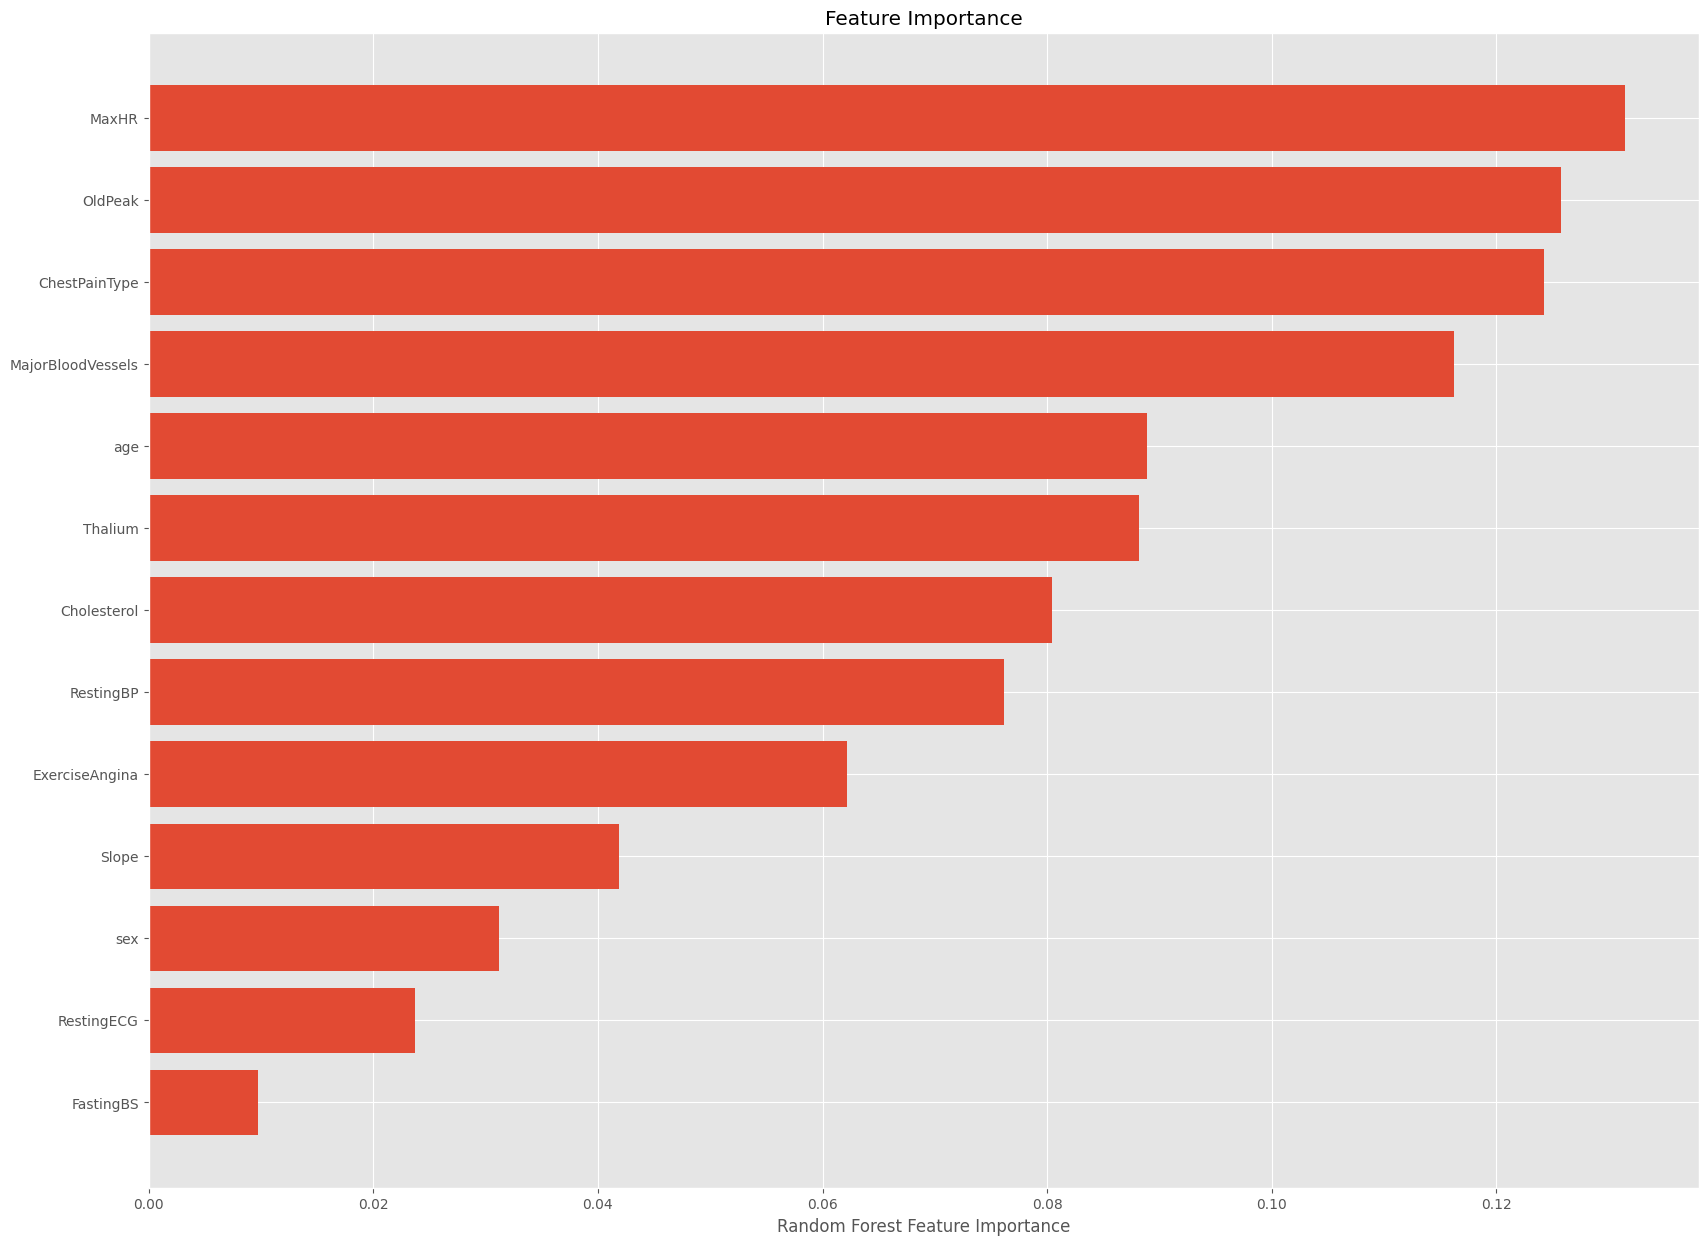

In [88]:
## Checking Feature importance 

plt.figure(figsize=(20,15))
importance = rf.feature_importances_
idxs = np.argsort(importance)
plt.title("Feature Importance")
plt.barh(range(len(idxs)),importance[idxs],align="center")
plt.yticks(range(len(idxs)),[num_col[i] for i in idxs])
plt.xlabel("Random Forest Feature Importance")
#plt.tight_layout()
plt.show()

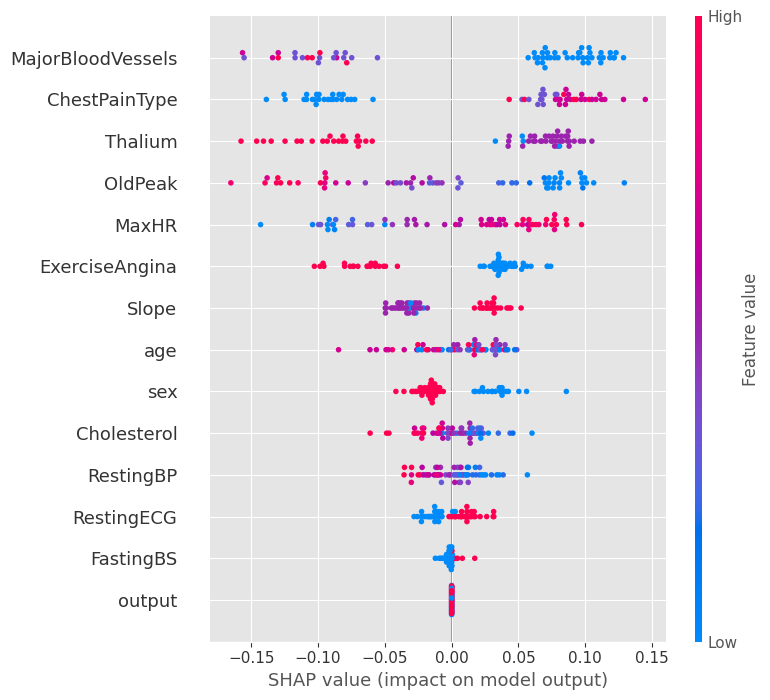

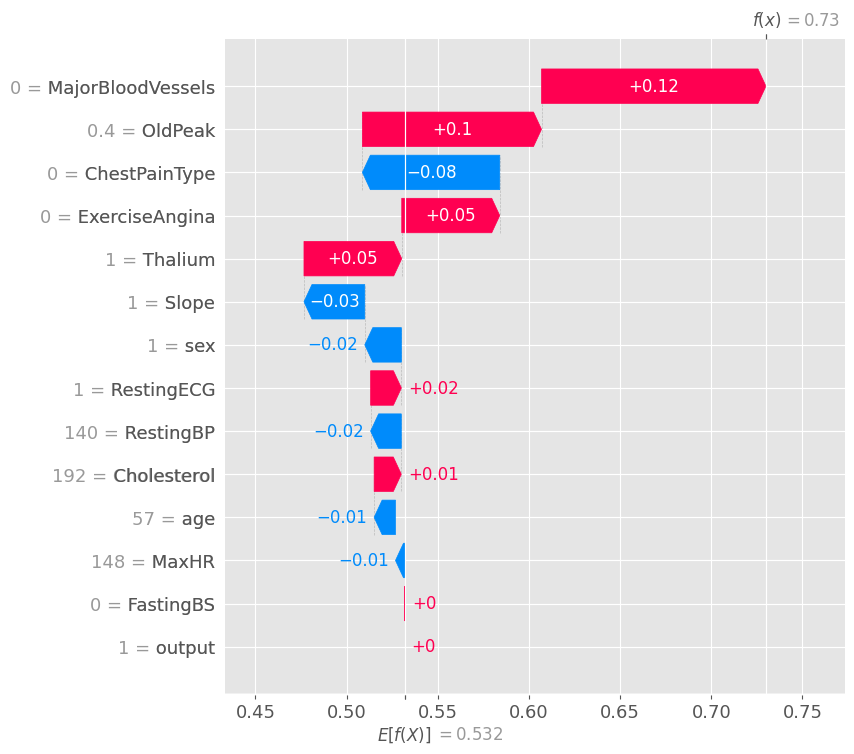

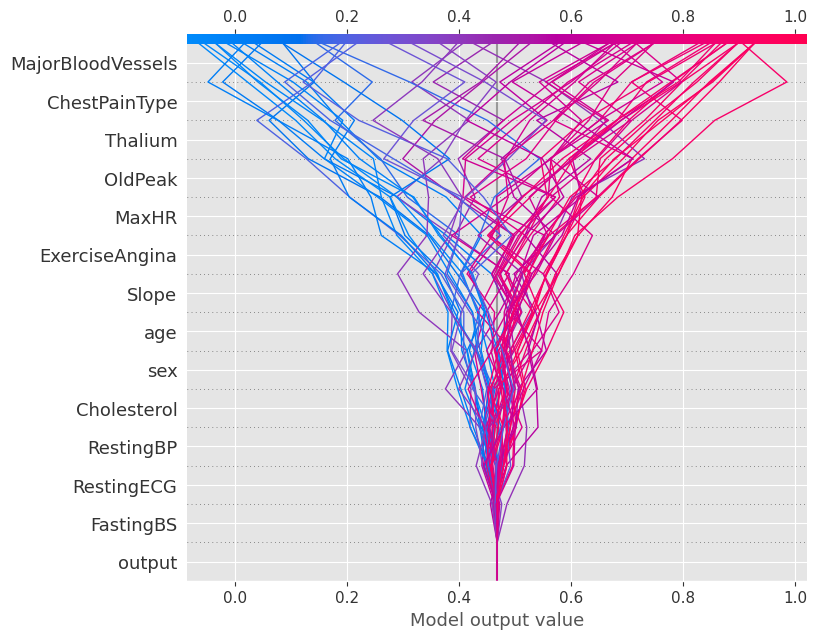

In [122]:
# shap.initjs()
# # Calculate SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_test)
sv = explainer.shap_values(X_test)

exp = shap.Explanation(shap_values.values[:,:,1], 
                  shap_values.base_values[:,1], 
                  data=X_test.values, 
                  feature_names=X_test.columns)
idx = 0
for i, col in enumerate(num_col, 1):
    shap.dependence_plot(f"{col}", sv[..., 1], X_test, show=False)
    plt.title(f"Feature Dependence Plot of {col}")
    plt.tight_layout()
    plt.show()
shap.summary_plot(sv[...,1], X_test)
shap.waterfall_plot(exp[idx], max_display=len(num_col)+1)
shap.decision_plot(explainer.expected_value[idx], sv[...,1], features=X_test)
shap.force_plot(explainer.expected_value[idx], sv[...,1], features=X_test)
